In [19]:
!git clone https://github.com/andssuu/PBEA7347.git

Cloning into 'PBEA7347'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 6), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (32/32), done.


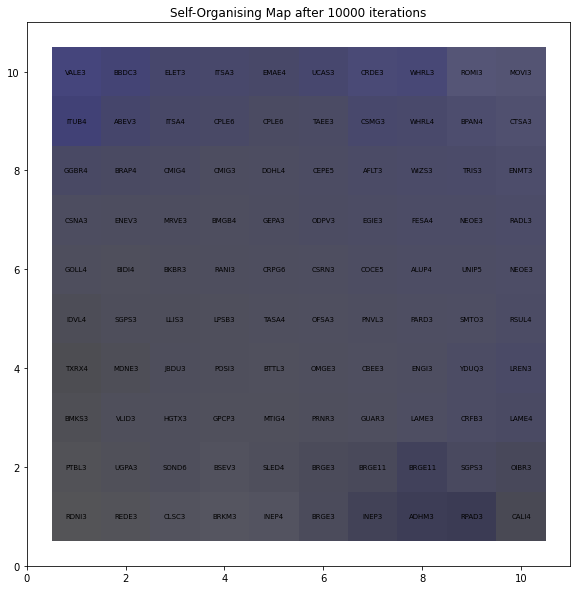

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from sklearn import preprocessing


def load_data(url):
    df = pd.read_csv('PBEA7347/data/b3_data_14012021.csv',
                     float_precision='high', sep=";")
    data = df.iloc[:, 3:]
    labels = df.iloc[:, 0]
    normalized_data = (data - data.min()) / (data.max() - data.min())
    return normalized_data, labels


def find_bmu(t, net, m):
    bmu_idx = np.array([0, 0])
    min_dist = np.iinfo(np.int).max
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    return (bmu, bmu_idx)


def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)


def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)


def compute_neighborhood(distance, radius):
    return np.exp(-distance / (2 * (radius**2)))


if __name__ == "__main__":
    # Tamanho do mapa
    X = 10
    Y = 10
    network_dimensions = np.array([X, Y])
    n_iterations = 10000
    init_learning_rate = 0.1
    # cria raio inicial de acordo com o tamanho inicial do mapa da SOM
    init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
    # constante de tempo que decai com o tempo
    time_constant = n_iterations / np.log(init_radius)
    # carrega a base de dados
    data, labels = load_data(local)
    # pega tamanho da base de dados
    m = data.shape[1]
    n = data.shape[0]
    # transforma rótulos do conjunto de treinamento em numeros pra mostrar no mapa
    le = preprocessing.LabelEncoder()
    le.fit(labels.values)
    training_labels_transformed = le.transform(labels.values)
    c = le.classes_
    label_map = np.zeros((X, Y, len(c)))
    # inicialização dos pesos m=dimensional pra cada neurônio da matriz SOM
    net = np.random.random((network_dimensions[0], network_dimensions[1], m))
    for i in range(n_iterations):
        random_example = np.random.randint(0, n)
        t = data.iloc[random_example].values.reshape(np.array([m, 1]))
        # calcula neurônio mais próximo a este exemplo (BMU)
        bmu, bmu_idx = find_bmu(t, net, m)
        # seleciona a classe do exemplo (Apenas pra vias de informação no mapa)
        class_index = list(c).index(labels[random_example])
        lab = label_map[bmu_idx[0], bmu_idx[1]]
        lab[class_index] = lab[class_index]+1
        # associa o neurônio a esta classe
        label_map[bmu_idx[0], bmu_idx[1]] = lab
        # Decresce os parâmetros da SOM
        r = decay_radius(init_radius, i, time_constant)
        l = decay_learning_rate(init_learning_rate, i, n_iterations)
        # Atualiza o vetor de Pesos da rede SOM para todos os neurônios da rede
        for x in range(net.shape[0]):
            for y in range(net.shape[1]):
                w = net[x, y, :].reshape(m, 1)
                # calcula a distância do neurônio ao neurônio vencedor
                w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                # se distância está dentro do raio estipulado r^2
                if w_dist <= r**2:
                    # calcula a função de vizinhança
                    influence = compute_neighborhood(w_dist, r)
                    # atualiza os pesos
                    # w(t+1) = w(t) + (learning rate * h * distancia)
                    new_w = w + (l * influence * (t - w))
                    # coloca o novo peso na rede na posição X,Y
                    net[x, y, :] = new_w.reshape(1, m)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, net.shape[0]+1))
    ax.set_ylim((0, net.shape[1]+1))
    ax.set_title('Self-Organising Map after %d iterations' % n_iterations)
    # plot the rectangles
    for x in range(1, net.shape[0] + 1):
        for y in range(1, net.shape[1] + 1):
            m = label_map[x-1, y-1]
            name_class = c[np.argmax(m)]
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                                           facecolor=[net[x-1, y-1, :].std(),
                                                      net[x-1, y-1, :].std(),
                                                      net[x-1, y-1, :].mean()
                                                      ],
                                           edgecolor='none'))
            ax.text(x, y, name_class,
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=7, color='black')
    plt.show()